## Neural networks

In [271]:
import torch
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

In [272]:
class Model(torch.nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super().__init__()
        self.hidden_layer = torch.nn.Linear(n_inputs, n_neurons)
        self.activation = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(n_neurons, 1)
        
        torch.nn.init.xavier_uniform_(self.hidden_layer.weight, gain=torch.nn.init.calculate_gain("relu"))
        torch.nn.init.xavier_uniform_(self.output_layer.weight, gain=torch.nn.init.calculate_gain("linear"))

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

    def predict(self, X):
        self.train(False)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            predictions = self.forward(X_tensor).numpy()
        return predictions

In [273]:
def train(
    model: torch.nn.Module, 
    training_loader: torch.utils.data.DataLoader,
    validation_loader: torch.utils.data.DataLoader,
    learning_rate: float,
    n_epochs: int):
 
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    validation_loss = []
    training_loss = []

    for epoch in range(n_epochs):
        model.train(True)
        current_epoch_loss = 0.0
        samples = 0
        for data in training_loader:
            model.zero_grad()
            inputs, labels = data
            outputs = model(inputs)
            loss_value = loss_function(outputs, labels)
            loss_value.backward()
            optimizer.step()
            current_epoch_loss += loss_value.item()*labels.shape[0]
            samples += labels.shape[0]

        training_loss.append(current_epoch_loss/samples)

        model.train(False)
        current_epoch_loss = 0.0
        samples = 0
        with torch.no_grad():
            for vdata in validation_loader:
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                current_epoch_loss += loss_function(voutputs, vlabels).item()*vlabels.shape[0]
                samples += vlabels.shape[0]
        
        validation_loss.append(current_epoch_loss/samples)

    history = {
        "training_loss": training_loss,
        "validation_loss": validation_loss
    }
    return model, history

In [274]:
df = pl.read_csv('data/gefcom.txt', separator='\t', has_header=True)
df

Date,Hour,Price,SystemLoad,Load,Weekday,
f64,f64,f64,f64,f64,f64,str
2.0110101e7,0.0,43.17,15187.0,5091.0,6.0,null
2.0110101e7,1.0,36.24,14464.0,4918.0,6.0,null
2.0110101e7,2.0,34.64,13940.0,4763.0,6.0,null
2.0110101e7,3.0,33.76,13609.0,4660.0,6.0,null
2.0110101e7,4.0,33.08,13391.0,4599.0,6.0,null
…,…,…,…,…,…,…
2.0131217e7,19.0,113.92,23091.0,7167.0,2.0,null
2.0131217e7,20.0,107.26,22504.0,6958.0,2.0,null
2.0131217e7,21.0,89.02,21538.0,6707.0,2.0,null


In [ ]:
df = df.with_columns(
    pl.col("Hour").cast(pl.UInt8),
    pl.col("Weekday").cast(pl.UInt8),
).drop(pl.col(""))

df = df.to_dummies("Weekday") 

df = df.with_columns(
    pl.col("Price").shift(24).alias("PriceLag1"),
    pl.col("Price").shift(48).alias("PriceLag2"),
    pl.col("Price").shift(168).alias("PriceLag7")
).drop_nulls()

df 

Date,Hour,Price,SystemLoad,Load,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Weekday_7,PriceLag1,PriceLag2,PriceLag7
f64,u8,f64,f64,f64,u8,u8,u8,u8,u8,u8,u8,f64,f64,f64
2.0110108e7,0,49.22,16269.0,5335.0,0,0,0,0,0,1,0,45.53,43.84,43.17
2.0110108e7,1,42.69,15568.0,5099.0,0,0,0,0,0,1,0,41.53,40.57,36.24
2.0110108e7,2,40.33,15160.0,4939.0,0,0,0,0,0,1,0,40.54,39.75,34.64
2.0110108e7,3,39.81,14912.0,4840.0,0,0,0,0,0,1,0,37.76,38.67,33.76
2.0110108e7,4,39.38,14783.0,4759.0,0,0,0,0,0,1,0,38.28,37.67,33.08
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2.0131217e7,19,113.92,23091.0,7167.0,0,1,0,0,0,0,0,138.15,98.03,63.34
2.0131217e7,20,107.26,22504.0,6958.0,0,1,0,0,0,0,0,135.53,90.93,57.0
2.0131217e7,21,89.02,21538.0,6707.0,0,1,0,0,0,0,0,110.64,85.37,53.52


In [289]:
X = df.select(pl.col(["PriceLag1", "PriceLag2", "PriceLag7", "SystemLoad",  "Weekday_1", "Weekday_2", "Weekday_3", "Weekday_4", "Weekday_5", "Weekday_6"])).to_numpy()
Y = df.select(pl.col("Price")).to_numpy()

T = (364-7)*24
Xtrain, Xtest = X[:T], X[T:]
Ytrain, Ytest = Y[:T], Y[T:]
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.1)

input_scaler = StandardScaler()
output_scaler = StandardScaler()

input_scaler.fit(Xtrain)
Xtrain = input_scaler.transform(Xtrain)
Xval = input_scaler.transform(Xval)

output_scaler.fit(Ytrain)
Ytrain = output_scaler.transform(Ytrain)
Yval = output_scaler.transform(Yval)

training_data = torch.utils.data.TensorDataset(
                    torch.tensor(Xtrain, dtype=torch.float32),
                    torch.tensor(Ytrain, dtype=torch.float32))
validation_data = torch.utils.data.TensorDataset(
                    torch.tensor(Xval, dtype=torch.float32),
                    torch.tensor(Yval, dtype=torch.float32))
        
training_loader = torch.utils.data.DataLoader(training_data, batch_size=256)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=256)

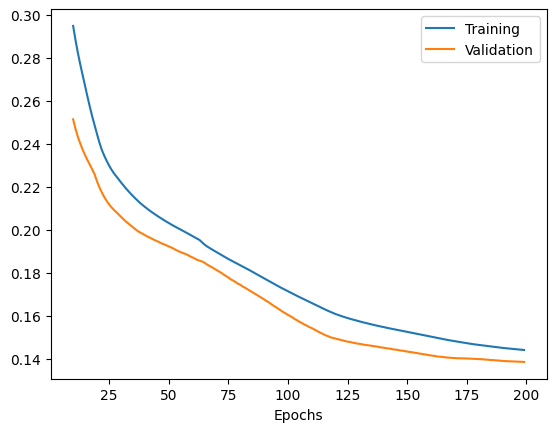

In [290]:
lr = 1e-3
epochs = 200
NARX = Model(10, 10)
NARX, history = train(NARX, training_loader, validation_loader, lr, epochs)

plt.plot(range(10, epochs), history["training_loss"][10:], label = "Training")
plt.plot(range(10, epochs), history["validation_loss"][10:], label = "Validation")
plt.xlabel("Epochs")
plt.legend()

In [292]:
predictions_NARX = output_scaler.inverse_transform(NARX.predict(input_scaler.transform(Xtest)))
np.mean(np.abs(Ytest - predictions_NARX))

np.float64(7.180554756418687)

In [ ]:
ARX = LinearRegression().fit(X, Y)
predictions_ARX = ARX.predict(Xtest)
np.mean(np.abs(Ytest - predictions_ARX))

np.float64(6.515440504586674)

In [294]:
predictions_ens_NARX = None
for r in range(10):
    NARX = Model(10, 10)
    NARX, _ = train(NARX, training_loader, validation_loader, lr, epochs)
    current = output_scaler.inverse_transform(NARX.predict(input_scaler.transform(Xtest)))
    if predictions_ens_NARX is None:
        predictions_ens_NARX = current/10
    else:
        predictions_ens_NARX += current/10
np.mean(np.abs(Ytest - predictions_ens_NARX))

np.float64(6.389769326872369)